### Домашнее задание №5.

***1. Для пайплайна (Case1) поэкспериментировать с разными моделями:
а)бустинг;
б)логистическая регрессия.***

***2. Отобрать лучшую модель по метрикам (какая здесь наиболее подходящая ML-метрика?).***

***3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, 
как в вопросе 2:
1 доллар на удержание;
2 доллара - с каждого правильно классифицированного (True Positive).***

**Импортируем необходимые библиотеки и скачаем данные.**

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [4]:
df = pd.read_csv('./churn_data.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [5]:
df.shape

(10000, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Посмотрим на распределение классов:**

In [7]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

**Сразу же будем работать с использованием Sklearn Pipeline. Категориальные признаки закодируем с помощью OneHotEncoding.
Вещественные оставим пока как есть.**

In [8]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

**Зададим списки признаков:**

In [10]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

**Создадим под каждый признак трансформер и объединим их в список:**

In [11]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

**Объединим все это в единый пайплайн:**

In [12]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

**Добавим и обучим несколько моделей ('CatBoostClassifier', 'XGBClassifier', 'RandomForestClassifier').** 

**Данные  метрик и оценку экономической эффективности моделей выведем в виде таблицы для удобства сравнения.**

**Подготовим словарь для результатов работы моделей:**

In [13]:
models_results = {
    'model': [],
    'F-Score': [],
    'Precision': [],
    'Recall': [],
    'Economy_effect': []
}

In [14]:
pipeline_cat = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(random_state=42))                                     
])

In [15]:
# pipeline = Pipeline([
#     ('features', feats),
#     ('classifier', CatBoostClassifier(auto_class_weights='Balanced', 
#                                       silent=True, random_state=42,
#                                       early_stopping_rounds=20))                                     
# ])

In [16]:
# обучим наш пайплайн
pipeline_cat.fit(X_train, y_train)

Learning rate set to 0.024355
0:	learn: 0.6726374	total: 49.1ms	remaining: 49s
1:	learn: 0.6548174	total: 55.3ms	remaining: 27.6s
2:	learn: 0.6405685	total: 58.3ms	remaining: 19.4s
3:	learn: 0.6237743	total: 62.6ms	remaining: 15.6s
4:	learn: 0.6080844	total: 67.1ms	remaining: 13.4s
5:	learn: 0.5929243	total: 71.6ms	remaining: 11.9s
6:	learn: 0.5787577	total: 75.8ms	remaining: 10.8s
7:	learn: 0.5659958	total: 80ms	remaining: 9.92s
8:	learn: 0.5556154	total: 84.2ms	remaining: 9.27s
9:	learn: 0.5441443	total: 88.3ms	remaining: 8.74s
10:	learn: 0.5348181	total: 92.5ms	remaining: 8.32s
11:	learn: 0.5257042	total: 95.5ms	remaining: 7.86s
12:	learn: 0.5169250	total: 99.6ms	remaining: 7.57s
13:	learn: 0.5074365	total: 104ms	remaining: 7.33s
14:	learn: 0.4985522	total: 108ms	remaining: 7.11s
15:	learn: 0.4914367	total: 112ms	remaining: 6.92s
16:	learn: 0.4826085	total: 117ms	remaining: 6.75s
17:	learn: 0.4757232	total: 121ms	remaining: 6.58s
18:	learn: 0.4680217	total: 125ms	remaining: 6.43s
19

197:	learn: 0.3138253	total: 864ms	remaining: 3.5s
198:	learn: 0.3136712	total: 869ms	remaining: 3.5s
199:	learn: 0.3135645	total: 874ms	remaining: 3.49s
200:	learn: 0.3134119	total: 878ms	remaining: 3.49s
201:	learn: 0.3133071	total: 883ms	remaining: 3.49s
202:	learn: 0.3130777	total: 888ms	remaining: 3.48s
203:	learn: 0.3129645	total: 892ms	remaining: 3.48s
204:	learn: 0.3127758	total: 896ms	remaining: 3.47s
205:	learn: 0.3124967	total: 900ms	remaining: 3.47s
206:	learn: 0.3123548	total: 904ms	remaining: 3.46s
207:	learn: 0.3122660	total: 907ms	remaining: 3.45s
208:	learn: 0.3120087	total: 911ms	remaining: 3.45s
209:	learn: 0.3119176	total: 915ms	remaining: 3.44s
210:	learn: 0.3118129	total: 920ms	remaining: 3.44s
211:	learn: 0.3117460	total: 924ms	remaining: 3.43s
212:	learn: 0.3116056	total: 928ms	remaining: 3.43s
213:	learn: 0.3113541	total: 932ms	remaining: 3.42s
214:	learn: 0.3111676	total: 936ms	remaining: 3.42s
215:	learn: 0.3110575	total: 940ms	remaining: 3.41s
216:	learn: 0.

366:	learn: 0.2920425	total: 1.55s	remaining: 2.67s
367:	learn: 0.2919367	total: 1.55s	remaining: 2.67s
368:	learn: 0.2918725	total: 1.56s	remaining: 2.66s
369:	learn: 0.2917870	total: 1.56s	remaining: 2.66s
370:	learn: 0.2916162	total: 1.57s	remaining: 2.66s
371:	learn: 0.2915264	total: 1.57s	remaining: 2.65s
372:	learn: 0.2913641	total: 1.57s	remaining: 2.65s
373:	learn: 0.2912911	total: 1.58s	remaining: 2.64s
374:	learn: 0.2912251	total: 1.58s	remaining: 2.64s
375:	learn: 0.2910964	total: 1.59s	remaining: 2.63s
376:	learn: 0.2910322	total: 1.59s	remaining: 2.63s
377:	learn: 0.2909866	total: 1.59s	remaining: 2.63s
378:	learn: 0.2908745	total: 1.6s	remaining: 2.62s
379:	learn: 0.2907327	total: 1.6s	remaining: 2.62s
380:	learn: 0.2906548	total: 1.61s	remaining: 2.61s
381:	learn: 0.2905668	total: 1.61s	remaining: 2.61s
382:	learn: 0.2903557	total: 1.61s	remaining: 2.6s
383:	learn: 0.2902225	total: 1.62s	remaining: 2.6s
384:	learn: 0.2900906	total: 1.62s	remaining: 2.59s
385:	learn: 0.29

527:	learn: 0.2732307	total: 2.21s	remaining: 1.97s
528:	learn: 0.2731091	total: 2.21s	remaining: 1.97s
529:	learn: 0.2730193	total: 2.22s	remaining: 1.97s
530:	learn: 0.2729174	total: 2.22s	remaining: 1.96s
531:	learn: 0.2727747	total: 2.23s	remaining: 1.96s
532:	learn: 0.2726631	total: 2.23s	remaining: 1.95s
533:	learn: 0.2725968	total: 2.23s	remaining: 1.95s
534:	learn: 0.2724663	total: 2.24s	remaining: 1.95s
535:	learn: 0.2723940	total: 2.24s	remaining: 1.94s
536:	learn: 0.2723136	total: 2.25s	remaining: 1.94s
537:	learn: 0.2722399	total: 2.25s	remaining: 1.93s
538:	learn: 0.2721912	total: 2.25s	remaining: 1.93s
539:	learn: 0.2720631	total: 2.26s	remaining: 1.92s
540:	learn: 0.2719685	total: 2.26s	remaining: 1.92s
541:	learn: 0.2718286	total: 2.27s	remaining: 1.91s
542:	learn: 0.2717301	total: 2.27s	remaining: 1.91s
543:	learn: 0.2716091	total: 2.27s	remaining: 1.91s
544:	learn: 0.2714656	total: 2.28s	remaining: 1.9s
545:	learn: 0.2713398	total: 2.28s	remaining: 1.9s
546:	learn: 0.

697:	learn: 0.2560289	total: 2.9s	remaining: 1.25s
698:	learn: 0.2559649	total: 2.9s	remaining: 1.25s
699:	learn: 0.2558692	total: 2.9s	remaining: 1.25s
700:	learn: 0.2558036	total: 2.91s	remaining: 1.24s
701:	learn: 0.2557106	total: 2.92s	remaining: 1.24s
702:	learn: 0.2556670	total: 2.92s	remaining: 1.23s
703:	learn: 0.2555648	total: 2.92s	remaining: 1.23s
704:	learn: 0.2554940	total: 2.93s	remaining: 1.22s
705:	learn: 0.2554497	total: 2.93s	remaining: 1.22s
706:	learn: 0.2552454	total: 2.93s	remaining: 1.22s
707:	learn: 0.2551547	total: 2.94s	remaining: 1.21s
708:	learn: 0.2551125	total: 2.94s	remaining: 1.21s
709:	learn: 0.2550375	total: 2.95s	remaining: 1.2s
710:	learn: 0.2549693	total: 2.95s	remaining: 1.2s
711:	learn: 0.2548765	total: 2.95s	remaining: 1.19s
712:	learn: 0.2547589	total: 2.96s	remaining: 1.19s
713:	learn: 0.2546930	total: 2.96s	remaining: 1.19s
714:	learn: 0.2546114	total: 2.96s	remaining: 1.18s
715:	learn: 0.2545285	total: 2.97s	remaining: 1.18s
716:	learn: 0.254

867:	learn: 0.2414953	total: 3.58s	remaining: 544ms
868:	learn: 0.2414401	total: 3.58s	remaining: 540ms
869:	learn: 0.2413696	total: 3.59s	remaining: 536ms
870:	learn: 0.2412852	total: 3.59s	remaining: 532ms
871:	learn: 0.2412021	total: 3.6s	remaining: 528ms
872:	learn: 0.2411157	total: 3.6s	remaining: 524ms
873:	learn: 0.2410512	total: 3.61s	remaining: 520ms
874:	learn: 0.2409808	total: 3.61s	remaining: 516ms
875:	learn: 0.2408490	total: 3.62s	remaining: 512ms
876:	learn: 0.2407881	total: 3.62s	remaining: 508ms
877:	learn: 0.2406894	total: 3.62s	remaining: 504ms
878:	learn: 0.2406367	total: 3.63s	remaining: 499ms
879:	learn: 0.2405835	total: 3.63s	remaining: 495ms
880:	learn: 0.2404916	total: 3.63s	remaining: 491ms
881:	learn: 0.2404056	total: 3.64s	remaining: 487ms
882:	learn: 0.2403417	total: 3.64s	remaining: 483ms
883:	learn: 0.2402392	total: 3.65s	remaining: 479ms
884:	learn: 0.2401893	total: 3.65s	remaining: 474ms
885:	learn: 0.2401013	total: 3.65s	remaining: 470ms
886:	learn: 0.

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [17]:
# наши прогнозы для тестовой выборки
preds_cat = pipeline_cat.predict_proba(X_test)[:, 1]
preds_cat[:10]

array([0.46917705, 0.24499582, 0.11518556, 0.04942908, 0.02369729,
       0.87775373, 0.02032456, 0.13019025, 0.16192791, 0.91391094])

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_cat)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3844764867775179, F-Score=0.645, Precision=0.661, Recall=0.629


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1827  164]
 [ 190  319]]


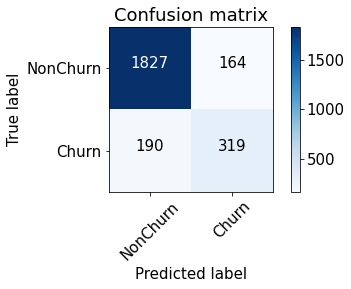

In [20]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_cat > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [21]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

economy_cat = income - retain_sum
economy_cat

155

In [22]:
models_results['model'].append('CatBoost')
models_results['F-Score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['Economy_effect'].append(economy_cat)

In [23]:
pipeline_xgb = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(random_state=42))                                     
])

In [24]:
# обучим наш пайплайн
pipeline_xgb.fit(X_train, y_train)

[16:25:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [25]:
preds_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
preds_xgb[:10]

array([0.47611395, 0.23087966, 0.0737261 , 0.03141731, 0.02561874,
       0.9679959 , 0.06951059, 0.2885457 , 0.11367497, 0.4902508 ],
      dtype=float32)

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_xgb)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.37331774830818176, F-Score=0.626, Precision=0.619, Recall=0.633


Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


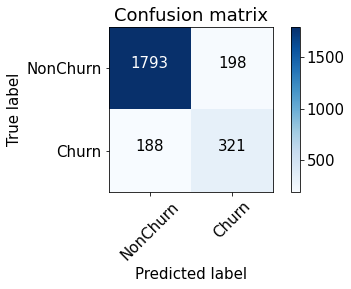

In [27]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_xgb > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [28]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

economy_xgb = income - retain_sum
economy_xgb

123

In [29]:
models_results['model'].append('XGB')
models_results['F-Score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['Economy_effect'].append(economy_xgb)

In [30]:
pipeline_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

In [31]:
# обучим наш пайплайн
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [32]:
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
preds_rf[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.38, F-Score=0.641, Precision=0.653, Recall=0.629


Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


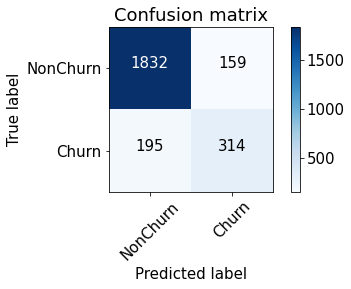

In [34]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_rf > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [35]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

economy_rf = income - retain_sum
economy_rf

155

In [36]:
models_results['model'].append('RandomForest')
models_results['F-Score'].append(fscore[ix])
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['Economy_effect'].append(economy_rf)

In [37]:
pd.DataFrame(data=models_results).sort_values('Economy_effect', ascending=False)

,model,F-Score,Precision,Recall,Economy_effect
0,CatBoost,0.644512,0.661157,0.628684,155
2,RandomForest,0.640641,0.653061,0.628684,155
1,XGB,0.625850,0.619231,0.632613,123


#### Для поставленной задачи (наибольший экономический эффект для бизнеса) наиболее всего подходит метрика F-Score. Она гармонически зависит сразу от двух показателей: Precision и Recall. Одновременная максимизация этих показателей дает наибольший экономический эффект от применения ML-прогноза.